In [1]:
import sys,os,errno,signal,copy
from contextlib import contextmanager

import numpy as np
import musicnet

import torch
from torch.autograd import Variable
from torch.nn.functional import conv1d, mse_loss

from time import time

import matplotlib.pyplot as plt
from IPython.display import Audio

from sklearn.metrics import average_precision_score

root = './data/'
checkpoint_path = './checkpoints'
checkpoint = 'musicnet_demo.pt'

try:
    os.makedirs(checkpoint_path)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

%matplotlib inline

In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='1'

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers

batch_size = 100
kwargs = {'num_workers': 4, 'pin_memory': True, 'worker_init_fn': worker_init}

m = 128
k = 500
d = 4096
window = 16384
stride = 512
regions = 1 + (window - d)/stride

In [3]:
train_set = musicnet.MusicNet(root=root, train=True, download=False, window=window)#, pitch_shift=5, jitter=.1)
test_set = musicnet.MusicNet(root=root, train=False, window=window, epoch_size=50000)

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

In [5]:
def create_filters(d,k,low=50,high=6000):
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((k,1,d), dtype=np.float32)
    wcos = np.empty((k,1,d), dtype=np.float32)
    start_freq = low
    end_freq = high
    num_cycles = start_freq*d/44000.
    scaling_ind = np.log(end_freq/start_freq)/k
    window_mask = 1.0-1.0*np.cos(x)
    for ind in range(k):
        wsin[ind,0,:] = window_mask*np.sin(np.exp(ind*scaling_ind)*num_cycles*x)
        wcos[ind,0,:] = window_mask*np.cos(np.exp(ind*scaling_ind)*num_cycles*x)
    
    return wsin,wcos

In [6]:
def L(y_hat, y):
    # adjust for per-frame loss
    return mse_loss(y_hat, y)*128/2.

In [7]:
class Model(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(Model, self).__init__()
        
        wsin,wcos = create_filters(d,k)
        with torch.cuda.device(0):
            self.wsin_var = Variable(torch.from_numpy(wsin).cuda(), requires_grad=False)
            self.wcos_var = Variable(torch.from_numpy(wcos).cuda(), requires_grad=False)
        print(regions*k)
        self.linear = torch.nn.Linear(int(regions*k), m, bias=False).cuda()
        torch.nn.init.constant(self.linear.weight, 0) # initialize
        
        self.avg = avg
        self.averages = copy.deepcopy(list(parm.data for parm in self.parameters()))
#         for (name,parm),pavg in zip(self.named_parameters(),self.averages):
#             print(name)
#             self.register_buffer(name + '_avg', pavg)
    
    def forward(self, x):
        zx = conv1d(x[:,None,:], self.wsin_var, stride=stride).pow(2) \
           + conv1d(x[:,None,:], self.wcos_var, stride=stride).pow(2)
        return self.linear(torch.log(zx + musicnet.epsilon).view(x.data.size()[0],int(regions*k)))
    
    def average_iterates(self):
        for parm, pavg in zip(self.parameters(), self.averages):
            pavg.mul_(self.avg).add_(1.-self.avg, parm.data)
            
                     

@contextmanager
def averages(model):
    orig_parms = copy.deepcopy(list(parm.data for parm in model.parameters()))
    for parm, pavg in zip(model.parameters(), model.averages):
        parm.data.copy_(pavg)
    yield
    for parm, orig in zip(model.parameters(), orig_parms):
        parm.data.copy_(orig)

# Train the model

In [8]:
model = Model()
model.cuda()
loss_history = []
avgp_history = []

12500.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  # This is added back by InteractiveShellApp.init_path()


In [9]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.000001, momentum=.95)

try:
    with train_set, test_set:
        print ('train loss\tsquare loss\tavg prec\ttime\t\tutime')
        for epoch in range(50):
            train_loss = 0.0
            t = time()
            for i, (x, y) in enumerate(train_loader):
                x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                loss = L(model(x),y)
                train_loss += loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                model.average_iterates()
            train_loss = train_loss/len(train_loader)   
            t1 = time()
            avgp, loss = 0., 0.
            yground = torch.FloatTensor(batch_size*len(test_loader), m)
            yhat = torch.FloatTensor(batch_size*len(test_loader), m)
            with averages(model):
                for i, (x, y) in enumerate(test_loader):
                    x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                    yhatvar = model(x)
                    loss += L(yhatvar,y).item()
                    yground[i*batch_size:(i+1)*batch_size,:] = y.data
                    yhat[i*batch_size:(i+1)*batch_size,:] = yhatvar.data
            avgp = average_precision_score(yground.numpy().flatten(),yhat.numpy().flatten())
            loss_history.append(loss/len(test_loader))
            avgp_history.append(avgp)
            torch.save(model.state_dict(), os.path.join(checkpoint_path,checkpoint))
            print ('{:2f}\t{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(train_loss, loss_history[-1],avgp_history[-1],time()-t, time()-t1))

except KeyboardInterrupt:
    print ('Graceful Exit')
else:
    print( 'Finished')

train loss	square loss	avg prec	time		utime
0.940159	0.982949	0.619067	22.575907	8.783660
0.888691	0.872459	0.634088	22.856360	8.544418
0.884255	0.803271	0.643493	22.782882	8.944074
0.878667	0.755072	0.649877	22.948173	8.833649
0.877371	0.724996	0.649209	22.635782	9.607205
0.872207	0.703829	0.654696	22.484923	8.794292
0.874993	0.696182	0.654944	23.010176	8.518365
0.875069	0.687442	0.658865	22.647439	8.913258
0.875035	0.685788	0.657826	22.547395	8.727486
0.872585	0.681757	0.661230	22.806928	9.781339
0.870516	0.678747	0.660488	22.281005	8.599476
0.871750	0.682679	0.657730	22.914200	8.453446
0.872148	0.683983	0.660684	22.699582	8.891239
0.872764	0.679152	0.663269	20.676417	8.310836
0.868674	0.683807	0.664610	20.392736	8.214303
0.883533	0.685996	0.660301	20.762635	8.388303
0.872121	0.686493	0.662549	20.483374	8.174041
0.874996	0.681610	0.663621	20.548486	8.249438
0.872672	0.687929	0.660608	20.794914	8.236666
0.873505	0.685380	0.662316	20.629963	8.316303
0.871738	0.684461	0.663961	20.738230

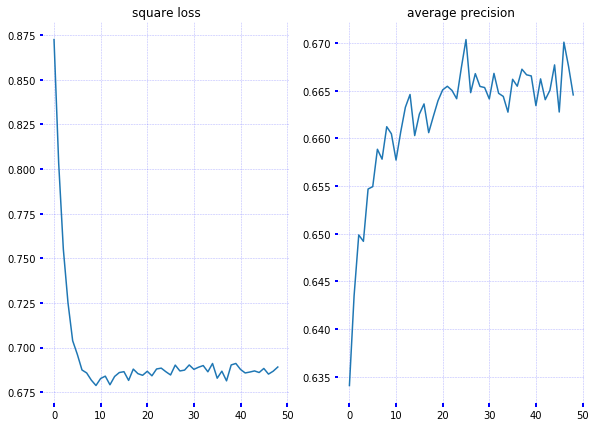

In [10]:
burnin = 1

fig = plt.figure(figsize=(15, 7))
fig.add_axes()

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)

for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.tick_params(direction='out', color='b', width='2')
    
ax1.set_title('square loss')
ax1.plot(np.arange(len(loss_history[burnin:])), loss_history[burnin:])
ax2.set_title('average precision')
ax2.plot(np.arange(len(avgp_history[burnin:])), avgp_history[burnin:])